# Problem Description
Smartphones have equipped us all with the ability to immediately announce an emergency whenever we encounter one. Because of this, several disaster-relief organizations are interested in monitoring twitter to be up-to-date on the most recent disasters people may be encountering.

In this project, given twitter data with labels indicating whether a tweet contains an emergency or not, the goal is to build a ML model that is able to predict if tweets contain emergency information in them.

In [1]:
from google.colab import files, drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import zipfile
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from collections import defaultdict
from transformers import BertTokenizer, BertModel

In [47]:
'''
Steps:
1) Apply transforms of data
2) Initialize data with Dataset and DataLoader Classes
3) Create model
4) Train Model with typical training loop
5) Evaluate Model with F1 Score
'''

'\nSteps:\n1) Apply transforms of data\n2) Initialize data with Dataset and DataLoader Classes\n3) Create model\n4) Train Model with typical training loop\n5) Evaluate Model with F1 Score\n'

In [48]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
zip_file_path = r'/content/drive/MyDrive/Colab Notebooks/ML3 Week 4 Programming Assignment/Data.zip'
extraction_path = r'/content/Data'

os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extraction_path)

In [50]:
train_df = pd.read_csv(r'/content/Data/train.csv')
test_df = pd.read_csv(r'/content/Data/test.csv')

In [51]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [53]:
train_df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


## Data Description
As can be seen in the data tables, there are 7613 tweets that I will be utilizing to train and evaluate my model. These tweets are classified as having disaster related content and non-disaster related content.

# Exploratory Data Analysis
In the EDA, I verify there are no null values in the target column, give some examples of disastrous tweets vs non-disastrous tweets, and show a pie chart that displays the distribution of the disastrous vs non-disastrous tweets.

In addition, I split the training set into a training and evaluation set, so I can get some indication on the model's performance before submitting to Kaggle. I then define some hyperparameters of my model, and decide to use the BertTokenizer for my word embedding technique. This tokenizer makes it easy to tokenize and pad the data which makes it suitable for use in the BERT model.

My dataset's and dataloader's then make use of the BertTokenizer to prepare the data for training.

In [54]:
# Make sure there are no missing target values
train_df['target'].isna().sum()

0

In [55]:
# Let's get some examples of disaster and non-disaster Tweets from the Tweet Book
print(f"Some examples of non-disaster tweets are:\n {train_df[train_df['target'] == 0]['text'].values[:5]}")
print(f"\nSome examples of disaster tweets are:\n {train_df[train_df['target'] == 1]['text'].values[:5]}")

Some examples of non-disaster tweets are:
 ["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is so fast'
 'What a goooooooaaaaaal!!!!!!']

Some examples of disaster tweets are:
 ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


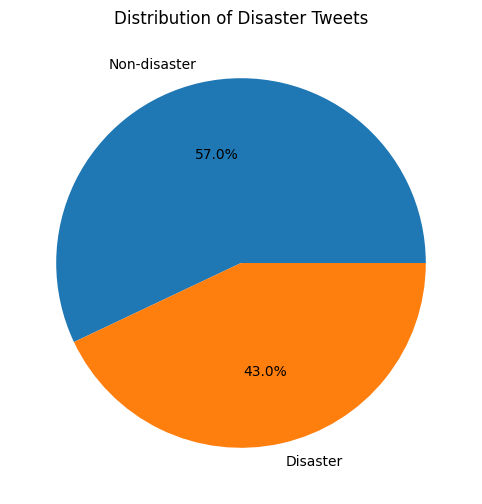

In [56]:
# Let's plot a pie chart to see the distribution of disaster tweets vs non-disaster tweets in the dataset
counts = train_df['target'].value_counts()
labels = ['Non-disaster' if counts.index[0] == 0 else 'Disaster', 'Disaster' if counts.index[0] == 0 else 'Non-disaster']
plt.figure(figsize=(10,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Disaster Tweets')
plt.show()

In [57]:
# Create the train-validation split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Define hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.00125

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
# Step 1: Define the Transforms of the Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = train_df['text'].apply(len).max()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [59]:
# Step 2 Initialize data with dataset and dataloader classes
class TweetDataset(Dataset):
  def __init__(self, data, tokenizer, max_length, test=False, transform=None):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.test = test

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    text = self.data.iloc[idx]['text']
    target = float('inf') if self.test else self.data.iloc[idx]['target']

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_token_type_ids=False,
        max_length=self.max_length,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'target': torch.tensor(target, dtype=torch.float)
    }

train_dataset = TweetDataset(train_df, tokenizer, max_length)
val_dataset = TweetDataset(val_df, tokenizer, max_length)
test_dataset = TweetDataset(test_df, tokenizer, max_length, test=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Architecture
The model to learn from the tweeter text utilizes both a BERT layer and a LSTM layer along with a linear layer to process the data and convert it to a number between 0 and 1 via the sigmoid function. BERT is a transformer-based Hugging Face model designed to understand the context and language of words in a text by learning in both directions, that is, left-to-right and right-to-left, simultaneously.

We freeze the BERT parameters from being updated since we have an extremely small dataset. This allows the model to update the parameters on the linear and LSTM layers, rather than the BERT layer, which already has very good pretrained parameters.

In [60]:
# Step 3: Create Model
class DisasterTweetLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, freeze_bert=True):
    super(DisasterTweetLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False

    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    lstm_input = bert_output.last_hidden_state
    out, _ = self.lstm(lstm_input)
    out = self.fc(out[:, -1, :])

    return torch.sigmoid(out)

input_size = 768
hidden_size = 128
output_size = 1

model = DisasterTweetLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


In [61]:
# Step 4: Train model with typical training loop
for epoch in range(num_epochs):
  model.train()
  for i, batch in enumerate(train_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    target = batch['target'].to(device)

    outputs = model(input_ids, attention_mask)
    loss = criterion(outputs, target.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.10f}')


Epoch [1/10], Step [1/191], Loss: 0.6596636772
Epoch [1/10], Step [21/191], Loss: 0.5831545591
Epoch [1/10], Step [41/191], Loss: 0.4504618347
Epoch [1/10], Step [61/191], Loss: 0.3598866761
Epoch [1/10], Step [81/191], Loss: 0.4719396830
Epoch [1/10], Step [101/191], Loss: 0.6238554120
Epoch [1/10], Step [121/191], Loss: 0.5538183451
Epoch [1/10], Step [141/191], Loss: 0.3590356410
Epoch [1/10], Step [161/191], Loss: 0.4793502092
Epoch [1/10], Step [181/191], Loss: 0.4121939242
Epoch [2/10], Step [1/191], Loss: 0.3762666583
Epoch [2/10], Step [21/191], Loss: 0.4922626019
Epoch [2/10], Step [41/191], Loss: 0.3219136894
Epoch [2/10], Step [61/191], Loss: 0.4207345247
Epoch [2/10], Step [81/191], Loss: 0.2639628649
Epoch [2/10], Step [101/191], Loss: 0.5401606560
Epoch [2/10], Step [121/191], Loss: 0.4794706702
Epoch [2/10], Step [141/191], Loss: 0.5084155798
Epoch [2/10], Step [161/191], Loss: 0.4824838042
Epoch [2/10], Step [181/191], Loss: 0.5094489455
Epoch [3/10], Step [1/191], Loss

In [62]:
# Step 5: Evaluate the model
model.eval()
with torch.no_grad():
  all_preds = []
  all_targets = []
  i = 0
  for batch in val_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    target = batch['target'].to(device)

    outputs = model(input_ids, attention_mask)
    predicted = (outputs>0.5).squeeze().int()

    all_preds.extend(predicted.cpu().numpy())
    all_targets.extend(target.cpu().numpy())

  f1 = f1_score(all_targets, all_preds, average='binary')
  accuracy = (np.array(all_preds) == np.array(all_targets)).mean()
  print(f'Validation Accuracy is {accuracy:.4f};\nF1 score is {f1}')

Validation Accuracy is 0.8017;
F1 score is 0.7633228840125392


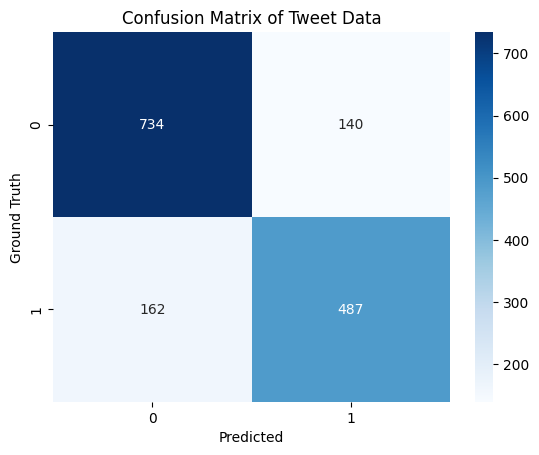

In [63]:
# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix of Tweet Data')
plt.show()

# Results and Analysis
In the above confusion matrix, you can see that the model was able to differentiate between disastrous and non-disastrous tweets fairly well. The model tended to predict that the tweet was not a disaster, so perhaps starting the model with different weights other than 0 might help the model predict more accurately.

Nonetheless, we were able to attain an 80% accuracy and 0.76 F1 score, so the model generalized pretty well.

In addition, after tuning the model several times, I discovered that using the BERT's pretrained parameters, rather than trying to update the parameters in my model, drastically increased the performance of my models. This is likely due to BERT having many parameters, so if I update them with my small training set, the model is likely to overfit the data.

# Conclusion
In conclusion, BERT's pretrained parameters proved to fit well to the tweet data, allowing the embeddings to produce very interpretable data in the LSTM model. Disaster relief organizations could have confidence when using this model, knowing that it is well trained to detect tweets containing disasters.

Perhaps a way to improve this model is to utilize the learning rate scheduler to narrow down on the gradients as they approach a minima.

In [64]:
# Evaluate the test dataset
with torch.no_grad():
  all_preds = []
  for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask)
    predicted = (outputs>0.5).squeeze().int()

    all_preds.extend(predicted.cpu().numpy())

# Submission File
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df['target'] = all_preds
submission_df.to_csv('/content/submission.csv', index=False)